In [58]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from model import Model
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [59]:

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_data = datasets.MNIST(root="./data", train=True, transform=train_transform, download=False)
val_data = datasets.MNIST(root="./data", train=False, transform=val_transform, download=False)

In [60]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [61]:
print("train: {}, val: {}".format(len(train_data), len(val_data)))

train: 60000, val: 10000


In [62]:
train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = data.DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)

In [74]:
# model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 28*28*1 -> 28*28*32
            nn.BatchNorm2d(32),  # 原始不存在
            nn.ReLU(),
            # nn.Conv2d(3,6,5), #32*32*3->28*28*6
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),  # 28*28*32 -> 28*28*32
            nn.BatchNorm2d(32),  # 原始不存在
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 14*14*32
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),  # 14*14*64
            nn.BatchNorm2d(64),  # 原始不存在
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),  # 14*14*64
            nn.BatchNorm2d(64),  # 原始不存在
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 7*7*16
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),  # 7*7*64
            nn.BatchNorm2d(128),  # 原始不存在
            nn.ReLU(),
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),  # 7*7*128
            nn.BatchNorm2d(128),  # 原始不存在
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 3*3*128
        )
        self.layer7 = nn.Sequential(
            nn.Linear(3 * 3 * 128, 120),
            nn.Linear(120, 84),
            nn.Linear(84, 2, bias=False),
            # nn.LeakyReLU(),
            # nn.ReLU
        )
        self.classifier = nn.Linear(2, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = x.view(x.size(0), -1)  # 展开成batch-size个1维数组
        feature = self.layer7(x)
        output = self.classifier(feature)
        return feature, output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
# print(model)

In [75]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           9,248
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,496
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
           Conv2d-11           [-1, 64, 14, 14]          36,928
      BatchNorm2d-12           [-1, 64, 14, 14]             128
             ReLU-13           [-1, 64, 14, 14]               0
        MaxPool2d-14             [-1, 6

In [76]:
# loss
criterion = nn.CrossEntropyLoss()

In [77]:
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.85)

In [78]:
def train(train_loader, model, optimizer):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for i, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device)
        feature, output = model(input)
        loss = criterion(output, target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predict = output.detach().cpu().numpy()
        predict = predict.argmax(axis=1)
        target = target.detach().cpu().numpy()
        acc = np.sum(predict==target) / len(predict)
        train_acc += acc
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    return train_loss, train_acc

In [79]:
def validation(val_loader, model, optimizer):
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.to(device)
            target = target.to(device)
            _, output = model(input)
            loss = criterion(output, target)
            val_loss += loss.item()
            predict = output.cpu().numpy()
            predict = predict.argmax(axis=1)
            target = target.cpu().numpy()
            acc = np.sum(target == predict) / len(predict)
            val_acc += acc
    val_loss = val_loss / len(val_loader)
    val_acc = val_acc / len(val_loader)
    return val_loss, val_acc

In [80]:
train_losses = []
val_losses = []
train_acces = []
val_acces = []
for i in range(100):
    scheduler.step()
    train_loss, train_acc = train(train_loader, model, optimizer)
    val_loss, val_acc = validation(val_loader, model, optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acces.append(train_acc)
    val_acces.append(val_acc)
    print("Epoch: {}".format(i))
    print("train loss: {}, train acc: {}".format(train_loss, train_acc))
    print("val loss: {}, val acc: {}".format(val_loss, val_acc))

Epoch: 0
train loss: 0.9015509802411233, train acc: 0.6831023454157783
val loss: 1.0578407669902608, val acc: 0.5849920382165605
Epoch: 1
train loss: 0.2207585502503269, train acc: 0.9467617270788913
val loss: 0.20077359235020958, val acc: 0.9519307324840764
Epoch: 2
train loss: 0.14455497841130316, train acc: 0.9653851279317697
val loss: 0.5582554403953491, val acc: 0.8522093949044586
Epoch: 3
train loss: 0.10920951170707817, train acc: 0.9747967750533049
val loss: 0.18906148233611114, val acc: 0.9443670382165605
Epoch: 4
train loss: 0.08668900654514207, train acc: 0.9785447761194029
val loss: 0.12640368302536617, val acc: 0.9735270700636943
Epoch: 5
train loss: 0.06925615609121094, train acc: 0.9829091151385928
val loss: 0.1107199802330345, val acc: 0.9739251592356688
Epoch: 6
train loss: 0.05317728714282706, train acc: 0.9866071428571429
val loss: 0.09839921091107806, val acc: 0.9798964968152867
Epoch: 7
train loss: 0.044722839004433614, train acc: 0.9885561034115139
val loss: 0.084

Epoch: 65
train loss: 0.0015153927144719594, train acc: 0.9999000533049041
val loss: 0.09332732913220763, val acc: 0.9863654458598726
Epoch: 66
train loss: 0.001503328469071561, train acc: 0.999933368869936
val loss: 0.0899359923164556, val acc: 0.9866640127388535
Epoch: 67
train loss: 0.0011205597123357532, train acc: 1.0
val loss: 0.09034400029926543, val acc: 0.9868630573248408
Epoch: 68
train loss: 0.0009621007800864767, train acc: 1.0
val loss: 0.09403613029391902, val acc: 0.9866640127388535
Epoch: 69
train loss: 0.0009564946550550237, train acc: 1.0
val loss: 0.10141282689988992, val acc: 0.9856687898089171
Epoch: 70
train loss: 0.0009517399772906354, train acc: 0.999983342217484
val loss: 0.09486780510206891, val acc: 0.9857683121019108
Epoch: 71
train loss: 0.0008863051499385062, train acc: 0.999983342217484
val loss: 0.09509721170565125, val acc: 0.9860668789808917
Epoch: 72
train loss: 0.0008133758328108391, train acc: 1.0
val loss: 0.09437972620414321, val acc: 0.9861664012

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

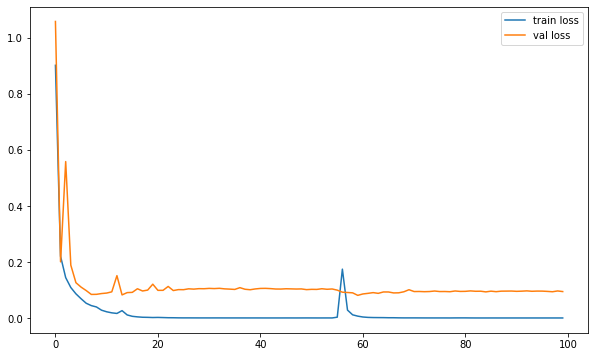

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(range(100), train_losses)
plt.plot(range(100), val_losses)
plt.legend(["train loss", "val loss"])
plt.show()

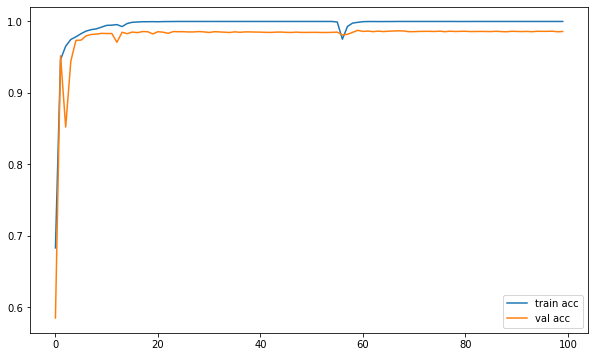

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(range(100), train_acces)
plt.plot(range(100), val_acces)
plt.legend(["train acc", "val acc" ])
plt.show()

In [86]:
torch.save(model.state_dict(), 'model_adam0.01_weight_decay0.0005_epoch50.pt')